# Lab 7 - Text classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!wget http://2019.poleval.pl/task6/task_6-2.zip
!wget http://2019.poleval.pl/task6/task6_test.zip
!unzip task_6-2.zip
!unzip task6_test.zip

In [3]:
train_set_text = []
test_set_text = []

with open("training_set_clean_only_text.txt") as fp:
    train_set_text = fp.readlines()
    train_set_text = [line.replace("@anonymized_account", "").strip() for line in train_set_text]
    
with open("Task6/task 02/test_set_only_text.txt") as fp:
    test_set_text = fp.readlines()
    test_set_text = [line.replace("@anonymized_account", "").strip() for line in test_set_text]

In [4]:
train_set_labels = []
test_set_labels = []

with open("training_set_clean_only_tags.txt") as fp:
    train_set_labels = fp.readlines()
    train_set_labels = [int(label) for label in train_set_labels]

with open("Task6/task 02/test_set_only_tags.txt") as fp:
    test_set_labels = fp.readlines()
    test_set_labels = [int(label) for label in test_set_labels]

In [5]:
train_task_2_labels = list(train_set_labels)
train_task_1_labels = [(0 if label == 0 else 1) for label in train_task_2_labels]

test_task_2_labels = list(test_set_labels)
test_task_1_labels = [(0 if label == 0 else 1) for label in test_task_2_labels]

In [6]:
print("Task 1:")
print(f"Train set ({len(train_task_1_labels)} items):")
print(f"0 class count: {sum([1 if label == 0 else 0 for label in train_task_1_labels])}")
print(f"1 class count: {sum([1 if label == 1 else 0 for label in train_task_1_labels])}")
print(f"Test set ({len(test_task_1_labels)} items):")
print(f"0 class count: {sum([1 if label == 0 else 0 for label in test_task_1_labels])}")
print(f"1 class count: {sum([1 if label == 1 else 0 for label in test_task_1_labels])}")
print("")
print("Task 2:")
print(f"Train set ({len(train_task_2_labels)} items):")
print(f"0 class count: {sum([1 if label == 0 else 0 for label in train_task_2_labels])}")
print(f"1 class count: {sum([1 if label == 1 else 0 for label in train_task_2_labels])}")
print(f"2 class count: {sum([1 if label == 1 else 0 for label in train_task_2_labels])}")
print(f"Test set ({len(test_task_2_labels)} items):")
print(f"0 class count: {sum([1 if label == 0 else 0 for label in test_task_2_labels])}")
print(f"1 class count: {sum([1 if label == 1 else 0 for label in test_task_2_labels])}")
print(f"2 class count: {sum([1 if label == 1 else 0 for label in test_task_2_labels])}")

Task 1:
Train set (10041 items):
0 class count: 9190
1 class count: 851
Test set (1000 items):
0 class count: 866
1 class count: 134

Task 2:
Train set (10041 items):
0 class count: 9190
1 class count: 253
2 class count: 253
Test set (1000 items):
0 class count: 866
1 class count: 25
2 class count: 25


### TF-IDF Naive-Bayes

In [ ]:
!pip install -U spacy

In [ ]:
!python -m spacy download pl_core_news_lg

In [ ]:
!wget https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt

In [10]:
stopwords = []
with open("polish.stopwords.txt") as file:
    stopwords = file.readlines()
    stopwords = [word.strip() for word in stopwords]

In [11]:
import spacy
from tqdm import tqdm

nlp = spacy.load("pl_core_news_lg")

In [12]:
train_docs = [nlp(text) for text in tqdm(train_set_text)]

100%|██████████| 10041/10041 [02:18<00:00, 72.57it/s]


In [13]:
test_docs = [nlp(text) for text in tqdm(test_set_text)]

100%|██████████| 1000/1000 [00:13<00:00, 76.08it/s]


In [14]:
train_tokenized = [[token.lemma_ for token in doc if token.lemma_.isalpha() and not token.lemma_ in stopwords] for doc in train_docs]
test_tokenized = [[token.lemma_ for token in doc if token.lemma_.isalpha() and not token.lemma_ in stopwords] for doc in test_docs]

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
train_tf_idf_docs = vectorizer.fit_transform([" ".join(tokens) for tokens in train_tokenized])
test_tf_idf_docs = vectorizer.transform([" ".join(tokens) for tokens in test_tokenized])

In [16]:
from sklearn.naive_bayes import MultinomialNB

def train_and_test_NB_model(X_train, y_train, X_test):
  mnb = MultinomialNB()
  mnb = mnb.fit(X_train, y_train)
  y_pred = mnb.predict(X_test)
  return mnb, y_pred

In [17]:
def transform_text(text):
  doc = nlp(text)
  cleaned_text = " ".join([token.lemma_ for token in doc if token.lemma_.isalpha() and not token.lemma_ in stopwords])
  return vectorizer.transform([cleaned_text])


In [18]:
from sklearn.metrics import matthews_corrcoef, f1_score

def get_metrics(y_test, y_pred, averages=['binary']):
  Acc = sum([pred == test for pred, test in zip(y_pred, y_test)])/len(y_test)
  F1 = [f1_score(y_test, y_pred, average=average) for average in averages]
  MCC = matthews_corrcoef(y_test, y_pred)
  return Acc, F1, MCC

def print_metrics(Acc, F1, MCC, f1_names=[""]):
  print(f"Accuracy: {Acc}, ", end = "")
  [print(f"F1 {f_name}: {f_score}, ", end="") for f_name, f_score in zip(f1_names,F1)]
  print(f"MCC: {MCC}")

In [19]:
NB_task1, y_pred_NB_task1 = train_and_test_NB_model(train_tf_idf_docs, train_task_1_labels, test_tf_idf_docs)
print(f"Task1:\nNaive Bayes - ", end="")
bayes_results_1 = get_metrics(test_task_1_labels, y_pred_NB_task1)
print_metrics(*bayes_results_1)

Task1:
Naive Bayes - Accuracy: 0.866, F1 : 0.0, MCC: 0.0


In [20]:
NB_task2, y_pred_NB_task2 = train_and_test_NB_model(train_tf_idf_docs, train_task_2_labels, test_tf_idf_docs)
print(f"Task2:\nNaive Bayes - ", end="")
bayes_results_2 = get_metrics(test_task_2_labels, y_pred_NB_task1, ['micro', 'macro'])
print_metrics(*bayes_results_2, ['micro', 'macro'])

Task2:
Naive Bayes - Accuracy: 0.866, F1 micro: 0.866, F1 macro: 0.3093962129331904, MCC: 0.0


### Fasttext

In [ ]:
!pip install fasttext

In [22]:
import fasttext

In [23]:
with open('task1.train', 'w') as file:
  for text, label in zip(train_set_text, train_task_1_labels):
    file.write(f"__label__{label} {text}\n")

with open('task1.test', 'w') as file:
  for text, label in zip(test_set_text, test_task_1_labels):
    file.write(f"__label__{label} {text}\n")

with open('task2.train', 'w') as file:
  for text, label in zip(train_set_text, train_task_2_labels):
    file.write(f"__label__{label} {text}\n")

with open('task2.test', 'w') as file:
  for text, label in zip(test_set_text, test_task_2_labels):
    file.write(f"__label__{label} {text}\n")

In [24]:
model_task1 = fasttext.train_supervised(input="task1.train")

In [38]:
int(model_task1.predict("Dzień doberek")[0][0][-1])

0

In [33]:
model_task1.test("task1.test")

(1000, 0.871, 0.871)

In [34]:
fasttest_task1_preds = [int(model_task1.predict(test_text)[0][0][-1]) for test_text in test_set_text]

In [35]:
print(f"Task 1:\nFasttext - ", end="")
fasttext_results_1 = get_metrics(test_task_1_labels, fasttest_task1_preds)
print_metrics(*fasttext_results_1)

Task 1:
Fasttext - Accuracy: 0.871, F1 : 0.19875776397515527, MCC: 0.22425449261805191


In [39]:
model_task2 = fasttext.train_supervised(input="task2.train")

In [40]:
model_task2.test("task2.test")

(1000, 0.864, 0.864)

In [41]:
fasttest_task2_preds = [int(model_task2.predict(test_text)[0][0][-1]) for test_text in test_set_text]

In [45]:
print(f"Task 2:\nFasttext - ", end="")
fasttext_results_2 = get_metrics(test_task_2_labels, fasttest_task2_preds, ['micro', 'macro'])
print_metrics(*fasttext_results_2, ['micro', 'macro'])

Task 2:
Fasttext - Accuracy: 0.864, F1 micro: 0.864, F1 macro: 0.3290332512315271, MCC: 0.09346712551754159


### Transformer

In [ ]:
!pip install transformers

In [47]:
import torch

class CustomTextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [49]:
torch.cuda.empty_cache()

In [50]:
from transformers import BertTokenizerFast, BertForSequenceClassification, AutoTokenizer
from transformers import Trainer, TrainingArguments

model_name = "allegro/herbert-base-cased"
max_length = 512
target_names_task1 = ["0", "1"]
target_names_task2 = ["0", "1", "2"]


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
bert_task1=BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names_task1))
bert_task2=BertForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names_task2))

In [52]:
bert_1_path = "/content/drive/MyDrive/Colab Notebooks/transformer_models/transformer_model_task1/"
bert_2_path = "/content/drive/MyDrive/Colab Notebooks/transformer_models/transformer_model_task2/"

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
bert_task1=BertForSequenceClassification.from_pretrained(bert_1_path, local_files_only=True)
bert_task2=BertForSequenceClassification.from_pretrained(bert_2_path, local_files_only=True)

In [ ]:
bert_task1.to(device)

In [ ]:
bert_task2.to(device)

In [53]:
train_encodings = tokenizer(train_set_text, truncation=True, padding=True, max_length=max_length)
train_dataset_1 = CustomTextDataset(train_encodings, train_task_1_labels)
train_dataset_2 = CustomTextDataset(train_encodings, train_task_2_labels)
test_encodings = tokenizer(test_set_text, truncation=True, padding=True, max_length=max_length)
test_dataset_1 = CustomTextDataset(test_encodings, test_task_1_labels)
test_dataset_2 = CustomTextDataset(test_encodings, test_task_2_labels)


In [56]:
from pathlib import Path

output_dir = "./transformer_model/"
Path(output_dir).mkdir(parents=True, exist_ok=True)

training_args = TrainingArguments(
    output_dir,
    num_train_epochs=10,
    per_device_train_batch_size=32,  # batch size per device during training
    weight_decay=0.01,               # strength of weight decay
    load_best_model_at_end=True,
    logging_steps=200,
    save_steps=600,
    evaluation_strategy="steps",
    dataloader_pin_memory=False,
)

trainer_1 = Trainer( model=bert_task1,args=training_args,train_dataset=train_dataset_1, eval_dataset=test_dataset_1)
trainer_2 = Trainer( model=bert_task2,args=training_args,train_dataset=train_dataset_2, eval_dataset=test_dataset_2)

In [ ]:
trainer_1.train()

***** Running training *****
  Num examples = 10041
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3140


Step,Training Loss,Validation Loss
200,0.242000,0.321878
400,0.222800,0.258359
600,0.170900,0.352744
800,0.117400,0.333484
1000,0.098000,0.422801
1200,0.066000,0.489453
1400,0.052300,0.560529
1600,0.040400,0.691377
1800,0.025000,0.841661
2000,0.019500,0.702871


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./transformer_model/checkpoint-600
Configuration saved in ./transformer_model/checkpoint-600/config.json
Model weights saved in ./transformer_model/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./transformer_model/checkpoint-1200
Configuration saved in ./transformer_model/checkpoint-1200/config.json
Model weights saved in ./transformer_model/checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluat

TrainOutput(global_step=3140, training_loss=0.06957544116837204, metrics={'train_runtime': 3210.8067, 'train_samples_per_second': 31.273, 'train_steps_per_second': 0.978, 'total_flos': 4385963653983000.0, 'train_loss': 0.06957544116837204, 'epoch': 10.0})

In [57]:
pred_probabilities1, labels1, stats1 = trainer_1.predict(test_dataset_1)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


In [58]:
stats1

{'test_loss': 0.3527436852455139,
 'test_runtime': 377.2122,
 'test_samples_per_second': 2.651,
 'test_steps_per_second': 0.331}

In [59]:
import numpy as np
bert_pred_1 = [np.argmax(probs) for probs in pred_probabilities1]

In [60]:
print(f"Task 1:\nTransformer - ", end="")
transformer_results_1 = get_metrics(test_task_1_labels, bert_pred_1)
print_metrics(*transformer_results_1)

Task 1:
Transformer - Accuracy: 0.893, F1 : 0.4216216216216216, MCC: 0.4292077133758999


In [ ]:
trainer_2.train()

***** Running training *****
  Num examples = 10041
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3140


Step,Training Loss,Validation Loss
200,0.304300,0.321112
400,0.239800,0.425601
600,0.268600,0.467441
800,0.263300,0.343774
1000,0.162200,0.349761
1200,0.127200,0.537234
1400,0.087000,0.559331
1600,0.088600,0.633820
1800,0.053700,0.709125
2000,0.031700,0.847801


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./transformer_model/checkpoint-600
Configuration saved in ./transformer_model/checkpoint-600/config.json
Model weights saved in ./transformer_model/checkpoint-600/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to ./transformer_model/checkpoint-1200
Configuration saved in ./transformer_model/checkpoint-1200/config.json
Model weights saved in ./transformer_model/checkpoint-1200/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluat

TrainOutput(global_step=3140, training_loss=0.10762088830303994, metrics={'train_runtime': 3205.4761, 'train_samples_per_second': 31.325, 'train_steps_per_second': 0.98, 'total_flos': 4386003033780900.0, 'train_loss': 0.10762088830303994, 'epoch': 10.0})

In [61]:
pred_probabilities2, labels2, stats2 = trainer_2.predict(test_dataset_2)

***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


In [62]:
stats2

{'test_loss': 0.46744129061698914,
 'test_runtime': 379.4222,
 'test_samples_per_second': 2.636,
 'test_steps_per_second': 0.329}

In [63]:
bert_pred_2 = [np.argmax(probs) for probs in pred_probabilities2]

In [64]:
print(f"Task 2:\nTransformer - ", end="")
transformer_results_2 = get_metrics(test_task_2_labels, bert_pred_2, ['micro', 'macro'])
print_metrics(*transformer_results_2, ['micro', 'macro'])

Task 2:
Transformer - Accuracy: 0.866, F1 micro: 0.866, F1 macro: 0.3093962129331904, MCC: 0.0


In [ ]:
bert_task1.save_pretrained("./transformer_model_task1/")

Configuration saved in ./transformer_model_task1/config.json
Model weights saved in ./transformer_model_task1/pytorch_model.bin


In [ ]:
bert_task2.save_pretrained("./transformer_model_task2/")

Configuration saved in ./transformer_model_task2/config.json
Model weights saved in ./transformer_model_task2/pytorch_model.bin


In [ ]:
!cp -R ./transformer_model_task1/ /content/drive/MyDrive/Colab\ Notebooks/transformer_models/transformer_model_task1/

In [ ]:
!cp -R ./transformer_model_task2/ /content/drive/MyDrive/Colab\ Notebooks/transformer_models/transformer_model_task2/

In [65]:
from tabulate import tabulate

def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

print("Task 1:")
print(tabulate([["Naive Bayes"] + flatten(list(bayes_results_1)), 
                ["Fasttext"] + flatten(list(fasttext_results_1)), 
                ["Transformer"] + flatten(list(transformer_results_1))], 
               headers=['Model name', 'Accuracy', 'F1', 'MCC']))
print("")
print("Task 2:")
print(tabulate([["Naive Bayes"] + flatten(list(bayes_results_2)), 
                ["Fasttext"] + flatten(list(fasttext_results_2)), 
                ["Transformer"] + flatten(list(transformer_results_2))], 
               headers=['Model name', 'Accuracy', 'F1 micro', 'F1 macro', 'MCC']))


Task 1:
Model name      Accuracy        F1       MCC
------------  ----------  --------  --------
Naive Bayes        0.866  0         0
Fasttext           0.871  0.198758  0.224254
Transformer        0.893  0.421622  0.429208

Task 2:
Model name      Accuracy    F1 micro    F1 macro        MCC
------------  ----------  ----------  ----------  ---------
Naive Bayes        0.866       0.866    0.309396  0
Fasttext           0.864       0.864    0.329033  0.0934671
Transformer        0.866       0.866    0.309396  0


### Lime

In [ ]:
!pip install lime

In [67]:
TP_idx = list(zip(bert_pred_1, test_task_1_labels)).index((1, 1))
TN_idx = list(zip(bert_pred_1, test_task_1_labels)).index((0, 0))
FP_idx = list(zip(bert_pred_1, test_task_1_labels)).index((1, 0))
FN_idx = list(zip(bert_pred_1, test_task_1_labels)).index((0, 1))

In [73]:
import lime
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["Non-harmful", "Harmful"])

In [80]:
def getTransformerPredict(texts, trainer=trainer_1):
  tokens = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
  res = trainer.predict(CustomTextDataset(tokens, [0]*len(texts)))
  return res[0]

In [81]:
def getNaiveBayesPredict(texts, NB=NB_task1):
  docs = [nlp(text) for text in texts]
  cleaned_texts = [" ".join([token.lemma_ for token in doc if token.lemma_.isalpha() and not token.lemma_ in stopwords]) for doc in docs]
  vectorized = vectorizer.transform(cleaned_texts)
  pred = NB.predict_proba(vectorized)
  return pred

In [91]:
def getFasttextPredict(texts, model=model_task1):
  probs = [(int(model_task1.predict(text)[0][0][-1]), model_task1.predict(text)[1][0]) for text in texts]
  return np.array([[prob, 1-prob] if index == 0 else [1-prob, prob] for index, prob in probs])

In [83]:
def explain_instance_for_models(idx, classifier_funcs, num_features=6):
  return [explainer.explain_instance(test_set_text[idx], 
                                     classifier_func, 
                                     num_features=num_features) for classifier_func in classifier_funcs]

In [96]:
TP_NB_exp, TP_FT_exp, TP_T_exp = explain_instance_for_models(TP_idx, [getNaiveBayesPredict, getFasttextPredict, getTransformerPredict])

***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


In [164]:
TN_NB_exp, TN_FT_exp, TN_T_exp = explain_instance_for_models(TN_idx, [getNaiveBayesPredict, getFasttextPredict, getTransformerPredict])

***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


In [165]:
FP_NB_exp, FP_FT_exp, FP_T_exp = explain_instance_for_models(FP_idx, [getNaiveBayesPredict, getFasttextPredict, getTransformerPredict])

***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


In [166]:
FN_NB_exp, FN_FT_exp, FN_T_exp = explain_instance_for_models(FN_idx, [getNaiveBayesPredict, getFasttextPredict, getTransformerPredict])

***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


In [103]:
print("True Positive:")
print(test_set_text[TP_idx])
print(tabulate([[*items] for items in zip(TP_NB_exp.as_list(), TP_FT_exp.as_list(), TP_T_exp.as_list())], 
               headers=['Naive Bayes', 'Fasttext', 'Transformer']))

True Positive:
Pluli na kobiet, ciagali, dzicz chora z nienawisci, cywilacja jest zakaz dziczy
Naive Bayes                       Fasttext                              Transformer
--------------------------------  ------------------------------------  -----------------------------------
('zakaz', -0.04107549803718047)   ('nienawisci', -0.12137136898943435)  ('Pluli', 0.6309495100843032)
('dziczy', 0.017276606937049292)  ('ciagali', -0.1208798214731349)      ('chora', 0.5821420631165107)
('kobiet', 0.005727773963561342)  ('kobiet', -0.049952882683270236)     ('dzicz', 0.47703518884655083)
('dzicz', 0.004139422068867261)   ('na', -0.03883571181008632)          ('kobiet', 0.42477516648254404)
('chora', 0.002981197391789598)   ('dziczy', 0.02562461098177573)       ('nienawisci', 0.32821279154459937)
('na', -0.00016991971268639277)   ('z', -0.02068290380738564)           ('dziczy', 0.21033427490517304)


In [167]:
print("True Negative:")
print(test_set_text[TN_idx])
print(tabulate([[*items] for items in zip(TN_NB_exp.as_list(), TN_FT_exp.as_list(), TN_T_exp.as_list())], 
               headers=['Naive Bayes', 'Fasttext', 'Transformer']))

True Negative:
Spoko, jak im Duda z Morawieckim zamówią po pięć piw to wszystko będzie ok.
Naive Bayes                            Fasttext                           Transformer
-------------------------------------  ---------------------------------  ------------------------------------
('ok', -0.02216499105991599)           ('będzie', -0.19841552107541036)   ('Duda', 0.9798964567464519)
('Spoko', -0.014286637280109453)       ('Duda', 0.16364041232345247)      ('Morawieckim', 0.43312369623477576)
('pięć', -0.007438871506646048)        ('wszystko', 0.11260292262834071)  ('Spoko', -0.41580901313101915)
('Morawieckim', 0.006941908140739546)  ('im', 0.10481933946870536)        ('im', 0.41225663051961575)
('piw', -0.006812042103404985)         ('Spoko', -0.10472895784549624)    ('ok', -0.3424102021126453)
('zamówią', 0.0033244923491843647)     ('ok', -0.06773275487257933)       ('zamówią', -0.3406465110070741)


In [168]:
print("False Positive:")
print(test_set_text[FP_idx])
print(tabulate([[*items] for items in zip(FP_NB_exp.as_list(), FP_FT_exp.as_list(), FP_T_exp.as_list())], 
               headers=['Naive Bayes', 'Fasttext', 'Transformer']))

False Positive:
No czy Prezes nie miał racji, mówiąc,ze to są zdradzieckie mordy? No czy nie miał racji?😁😁
Naive Bayes                             Fasttext                          Transformer
--------------------------------------  --------------------------------  ------------------------------------
('miał', -0.015976139584223104)         ('mordy', 0.02440650432848053)    ('mordy', 2.7542646818490573)
('racji', -0.010552461833066577)        ('racji', -0.023059534897006358)  ('zdradzieckie', 1.0058429476782418)
('mówiąc', -0.010396575998084726)       ('No', -0.020303322727347903)     ('to', 0.09739160496110293)
('Prezes', -0.008054799182004184)       ('ze', -0.01449778353487601)      ('nie', 0.06663064436803273)
('mordy', 0.005189161512354974)         ('miał', -0.014006503492673076)   ('No', 0.056546020539018985)
('zdradzieckie', 0.002697913421538292)  ('nie', 0.013447641460207651)     ('ze', -0.054657039422832475)


In [169]:
print("False Negative:")
print(test_set_text[FN_idx])
print(tabulate([[*items] for items in zip(FN_NB_exp.as_list(), FN_FT_exp.as_list(), FN_T_exp.as_list())], 
               headers=['Naive Bayes', 'Fasttext', 'Transformer']))

False Negative:
Tej szmaty się nie komentuje
Naive Bayes                         Fasttext                               Transformer
----------------------------------  -------------------------------------  -----------------------------------
('szmaty', 0.08672398846642425)     ('szmaty', 0.02002864940751425)        ('się', -0.2888003005761048)
('komentuje', -0.0757745511241951)  ('nie', 0.017073807329943163)          ('szmaty', 0.21051513756171047)
('nie', 0.003355986349881543)       ('Tej', 0.012719949922457983)          ('nie', -0.11262536426716166)
('się', 0.0031592873914388993)      ('się', -0.005142605231604949)         ('komentuje', -0.10082491081538977)
('Tej', 0.0024517248405343584)      ('komentuje', -0.0003367357113652666)  ('Tej', -0.06697947688845668)


In [173]:
import matplotlib
import matplotlib.pyplot as plt

def plot_exp(model_name, exp, fig, axs, plot_pos, label=1):
  exp_list = exp.as_list()
  #fig, axs = plt.figure(figsize=figsize)
  vals = [x[1] for x in exp_list]
  names = [x[0] for x in exp_list]
  vals.reverse()
  names.reverse()
  colors = ['green' if x > 0 else 'red' for x in vals]
  pos = np.arange(len(exp_list)) + .5
  axs[plot_pos].barh(pos, vals, align='center', color=colors)
  plt.sca(axs[plot_pos])
  plt.yticks(pos, names)
  if exp.mode == "classification":
      title = 'Local explanation for class %s' % exp.class_names[label]
  else:
      title = 'Local explanation'
  axs[plot_pos].set_title(model_name + "\n" + title)

plt.rcParams['figure.figsize'] = [22, 8]

In [ ]:
#fig_NB = TP_NB_exp.as_pyplot_figure().suptitle("Naive Bayes")
#fig_FT = TP_FT_exp.as_pyplot_figure().suptitle("Fasttext")
#fig_T = TP_T_exp.as_pyplot_figure().suptitle("Transformer")

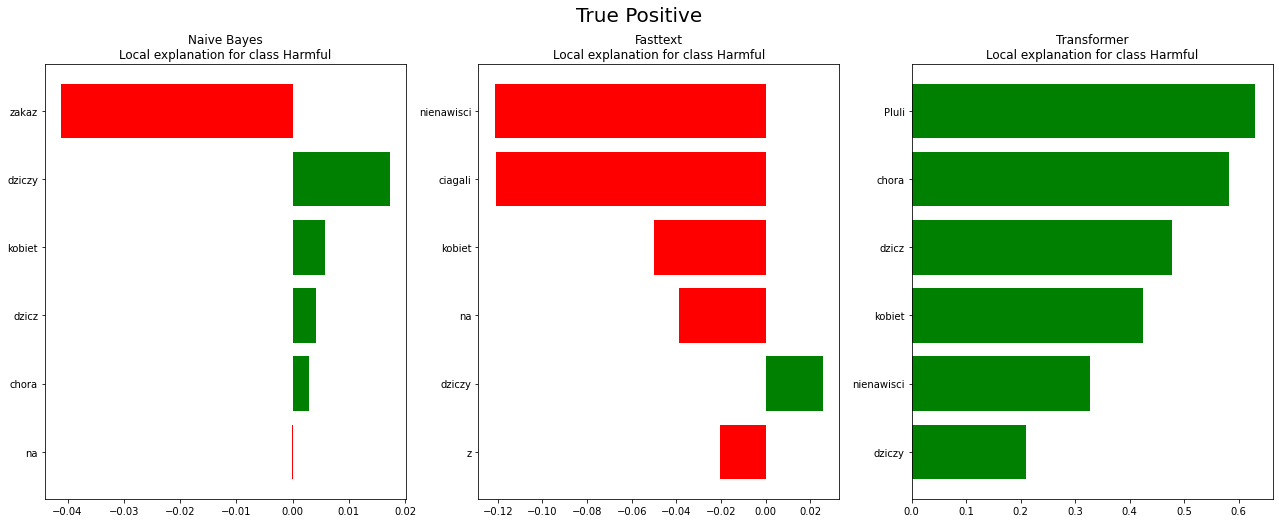

In [174]:
fig, axs = plt.subplots(1, 3)
fig.suptitle("True Positive", fontsize=20)
plot_exp("Naive Bayes", TP_NB_exp, fig, axs, 0)
plot_exp("Fasttext", TP_FT_exp, fig, axs, 1)
plot_exp("Transformer", TP_T_exp, fig, axs, 2)

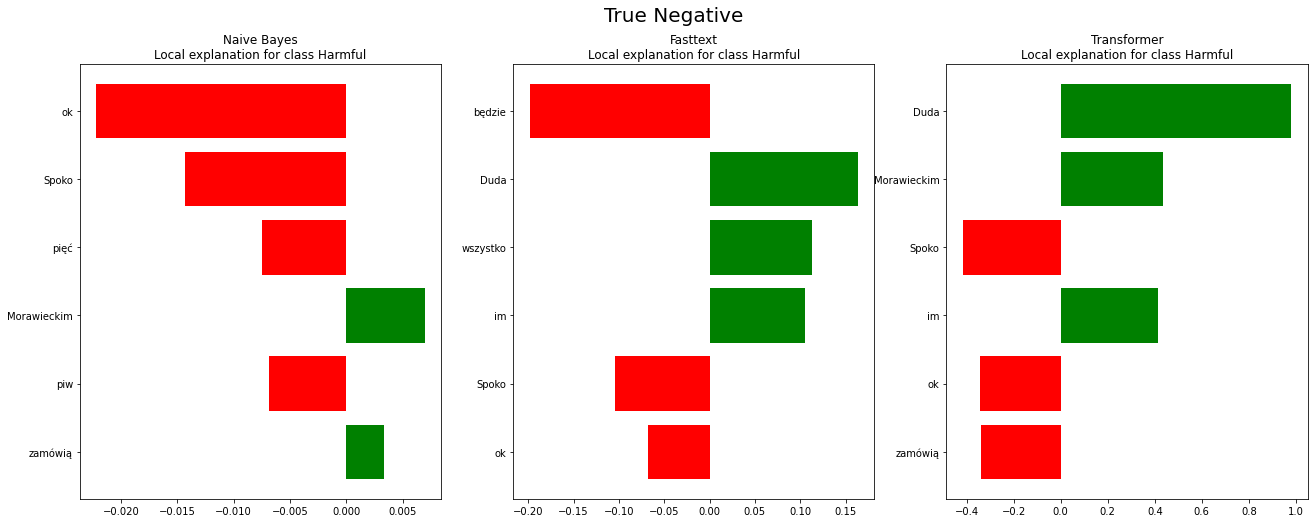

In [175]:
fig, axs = plt.subplots(1, 3)
fig.suptitle("True Negative", fontsize=20)
plot_exp("Naive Bayes", TN_NB_exp, fig, axs, 0)
plot_exp("Fasttext", TN_FT_exp, fig, axs, 1)
plot_exp("Transformer", TN_T_exp, fig, axs, 2)

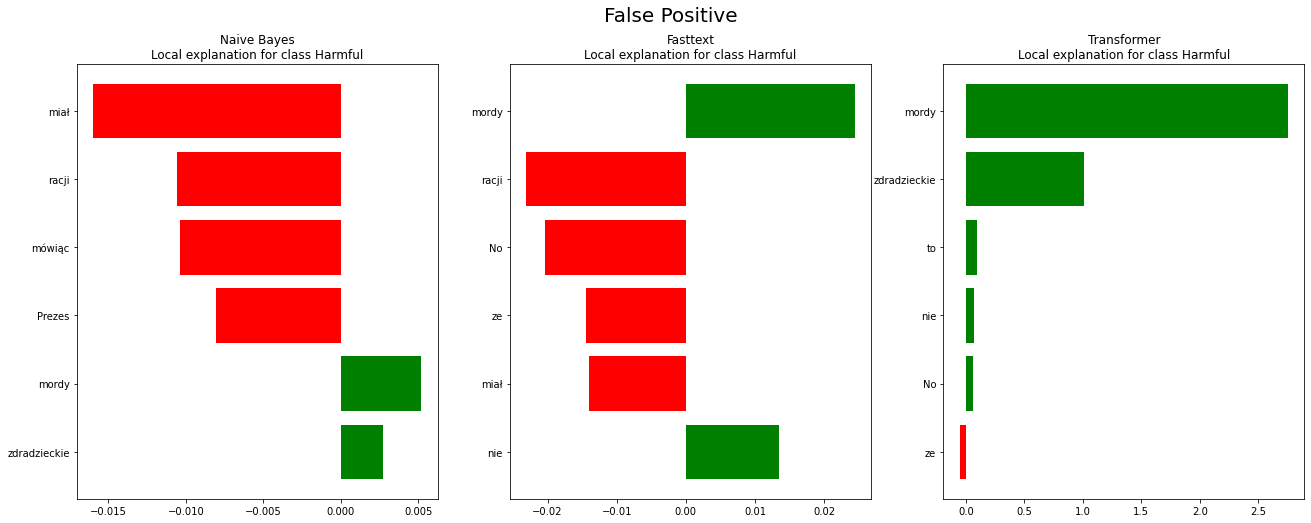

In [176]:
fig, axs = plt.subplots(1, 3)
fig.suptitle("False Positive", fontsize=20)
plot_exp("Naive Bayes", FP_NB_exp, fig, axs, 0)
plot_exp("Fasttext", FP_FT_exp, fig, axs, 1)
plot_exp("Transformer", FP_T_exp, fig, axs, 2)

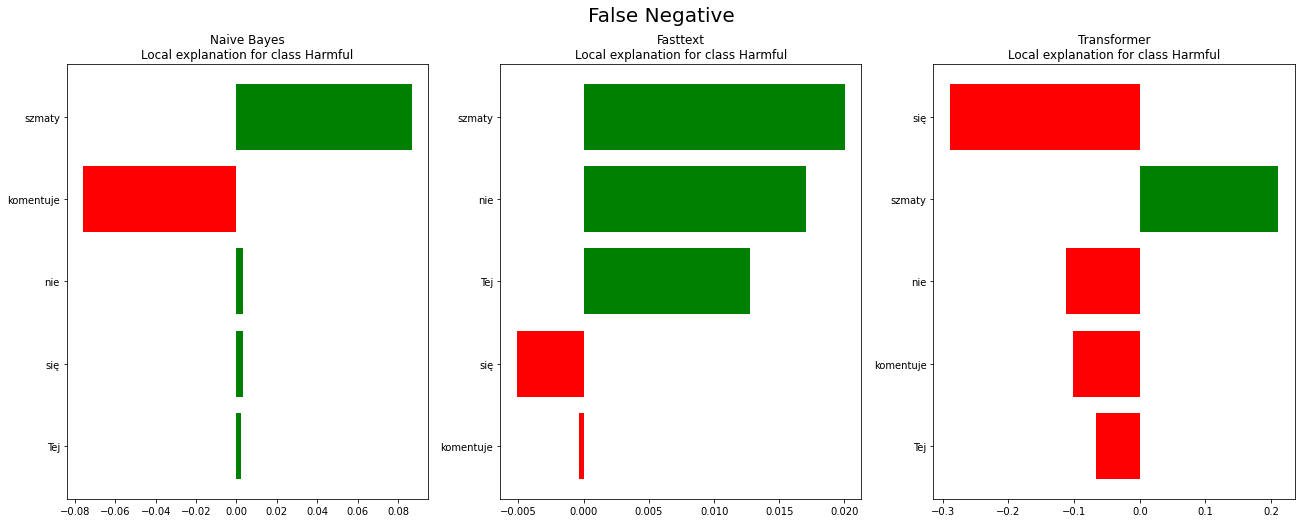

In [177]:
fig, axs = plt.subplots(1, 3)
fig.suptitle("False Negative", fontsize=20)
plot_exp("Naive Bayes", FN_NB_exp, fig, axs, 0)
plot_exp("Fasttext", FN_FT_exp, fig, axs, 1)
plot_exp("Transformer", FN_T_exp, fig, axs, 2)

### Odpowiedzi na pytania

**Which of the classifiers works the best for the task 1 and the task 2.** <br>
Dla obu zadań najlepsze wyniki dał model Transformer, ale wszystkie modele dały zbliżone wyniki.

**Did you achieve results comparable with the results of PolEval Task?** <br>
Wyniki otrzymane były nieco gorsze niż w PolEval Task, głównie różnią się wyniki dla miary F1.

**Did you achieve results comparable with the Klej leaderboard?** <br>
Uzyskałem podobny wynik do modelu PolBERTa (nawet troszkę lepszy), ale znacznie gorszy od najlepszych modeli w tabeli.

**Describe strengths and weaknesses of each of the compared algorithms.** <br>
Klasyfikator Bayesa jest relatywnie prostym i szybkim algorytmem dającym zaskakująco dobre wyniki.
Biblioteka fasttext jest prosta w użyciu i daje całkiem niezłe wyniki.
Transformer jest najwolniejszy z modeli, ale daje najlepsze wyniki, prawdopodobnie przy większej ilości danych do uczenia dawałby je jeszcze lepsze.

**Do you think comparison of raw performance values on a single task is enough to assess the value of a given algorithm/model?** <br>
Nie, gdyż każde zadanie trochę się od siebie różni i dopiero po przetestowaniu na większej ilości możemy zobaczyć ogólny performance modelu.

**Did SHAP show that the models use valuable features/words when performing their decision?** <br>
Tak SHAP pokazał słowa które najbardziej wpływały na decyzje modelu, w większości przypadków, słowa i ich wpływ na wynik były sensowne.

